<a href="https://colab.research.google.com/github/robd123/AML/blob/main/Project4/Project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import urllib.request
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import graphviz
from matplotlib import figure, pyplot
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
datapath = os.path.join("datasets", "customer", "")
os.makedirs(datapath, exist_ok=True)

# Dataset is already split into test and train data
file_path_train = "https://raw.githubusercontent.com/robd123/AML/main/Project4/CustomerTrain.csv"
file_path_test = "https://raw.githubusercontent.com/robd123/AML/main/Project4/CustomerTest.csv"

urllib.request.urlretrieve(file_path_train, datapath + "CustomerTrain.csv")
train_data = pd.read_csv(datapath + "CustomerTrain.csv", thousands=',')

urllib.request.urlretrieve(file_path_test, datapath + "CustomerTest.csv")
test_data = pd.read_csv(datapath + "CustomerTest.csv", thousands=',')

# Combine test and train data so I have a larger dataset, and only need to run my pipeline once
# Will split again using sklearn before prediction
customer_data = pd.concat([train_data, test_data])

print(customer_data.shape)
print(customer_data.head())

(10695, 11)
       ID  Gender Ever_Married  ...  Family_Size  Var_1 Segmentation
0  462809    Male           No  ...          4.0  Cat_4            D
1  462643  Female          Yes  ...          3.0  Cat_4            A
2  466315  Female          Yes  ...          1.0  Cat_6            B
3  461735    Male          Yes  ...          2.0  Cat_6            B
4  462669  Female          Yes  ...          6.0  Cat_6            A

[5 rows x 11 columns]


**Look for Missing Data**

In [4]:
print(customer_data.isnull().sum())

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64


**Determine Data Types**

In [5]:
print(customer_data.dtypes)

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object


**Convert all Object Types to Category Types**

In [6]:
customer_data['Gender'] = pd.Categorical(customer_data["Gender"])
customer_data['Ever_Married'] = pd.Categorical(customer_data["Ever_Married"])
customer_data['Graduated'] = pd.Categorical(customer_data["Graduated"])
customer_data['Profession'] = pd.Categorical(customer_data["Profession"])
customer_data['Spending_Score'] = pd.Categorical(customer_data["Spending_Score"])
customer_data['Var_1'] = pd.Categorical(customer_data["Var_1"])
customer_data['Segmentation'] = pd.Categorical(customer_data["Segmentation"])
print(customer_data.dtypes)

ID                    int64
Gender             category
Ever_Married       category
Age                   int64
Graduated          category
Profession         category
Work_Experience     float64
Spending_Score     category
Family_Size         float64
Var_1              category
Segmentation       category
dtype: object


**Plot Customer Type by Gender**

---
The remaining plots use pivot tables.  I learned.pandas pivot_table() after trying to find a better way of doing this.


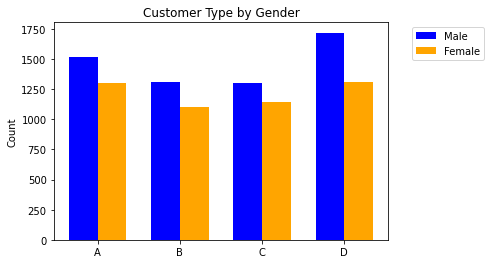

In [7]:
male = customer_data[customer_data.Gender == 'Male']
female = customer_data[customer_data.Gender == 'Female']
count_male_A = len(male[male.Segmentation == 'A'])
count_male_B = len(male[male.Segmentation == 'B'])
count_male_C = len(male[male.Segmentation == 'C'])
count_male_D = len(male[male.Segmentation == 'D'])
count_female_A = len(female[female.Segmentation == 'A'])
count_female_B = len(female[female.Segmentation == 'B'])
count_female_C = len(female[female.Segmentation == 'C'])
count_female_D = len(female[female.Segmentation == 'D'])

male_count = [count_male_A, count_male_B, count_male_C, count_male_D]
female_count = [count_female_A, count_female_B, count_female_C, count_female_D]

labels = ['A', 'B', 'C', 'D']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male_count, width, label='Male', color='blue')
rects2 = ax.bar(x + width/2, female_count, width, label='Female', color='orange')

ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

plt.title('Customer Type by Gender')
plt.show()

**Customer Type by Spending Score**

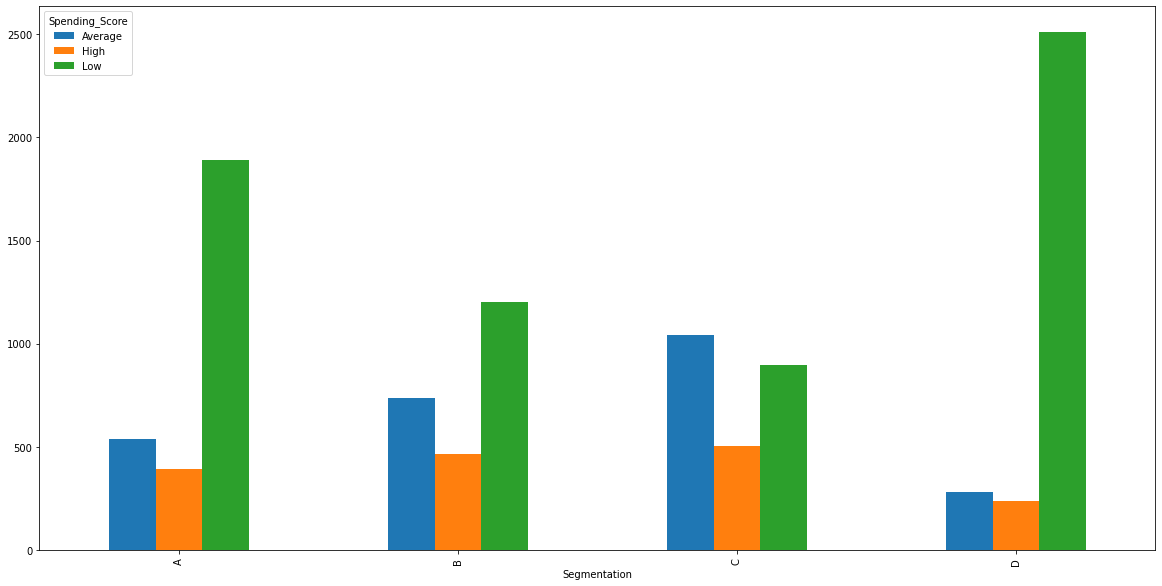

In [8]:
score_pv = pd.pivot_table(customer_data, values = 'ID', index = ['Segmentation'], columns = ['Spending_Score'], aggfunc=np.count_nonzero)
plt = score_pv.plot(kind='bar', figsize=(20,10))

**Customer Type by Marital Status**

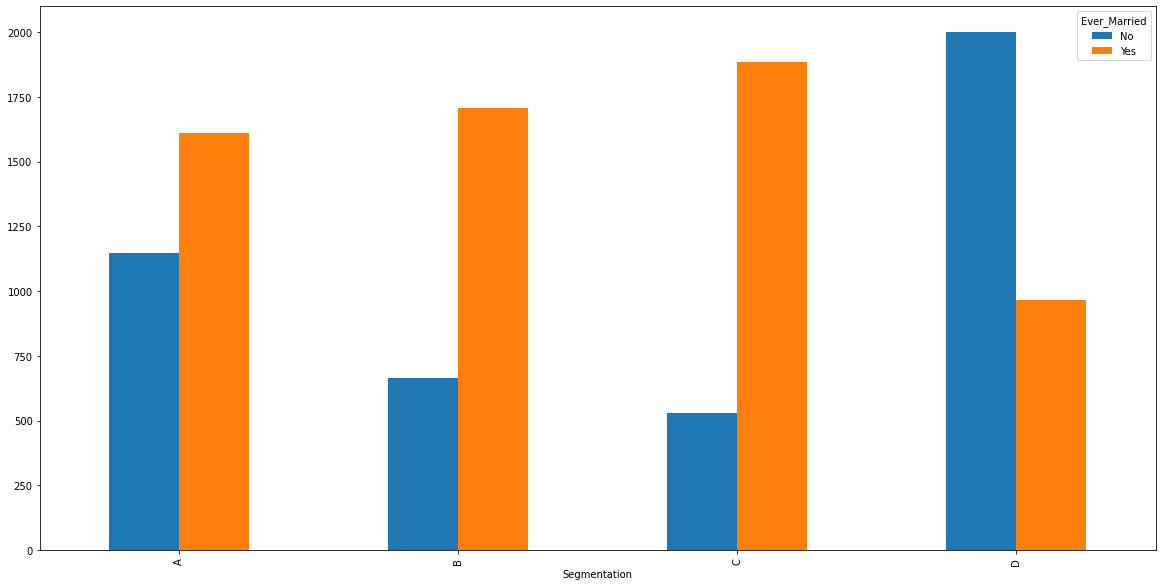

In [9]:
married_pv = pd.pivot_table(customer_data, values = 'ID', index = ['Segmentation'], columns = ['Ever_Married'], aggfunc=np.count_nonzero)
plt = married_pv.plot(kind='bar', figsize=(20,10))

**Customer Type by Profession**

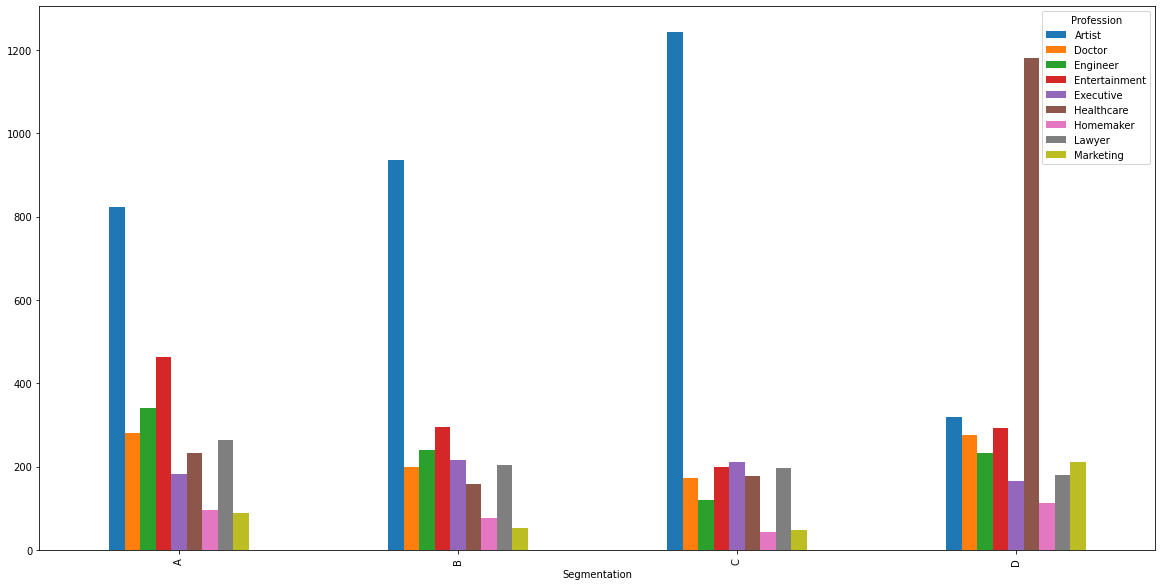

In [10]:
profession_pv = pd.pivot_table(customer_data, values = 'ID', index = ['Segmentation'], columns = ['Profession'], aggfunc=np.count_nonzero)
plt = profession_pv.plot(kind='bar', figsize=(20,10))

**Customer Type by Median Age**

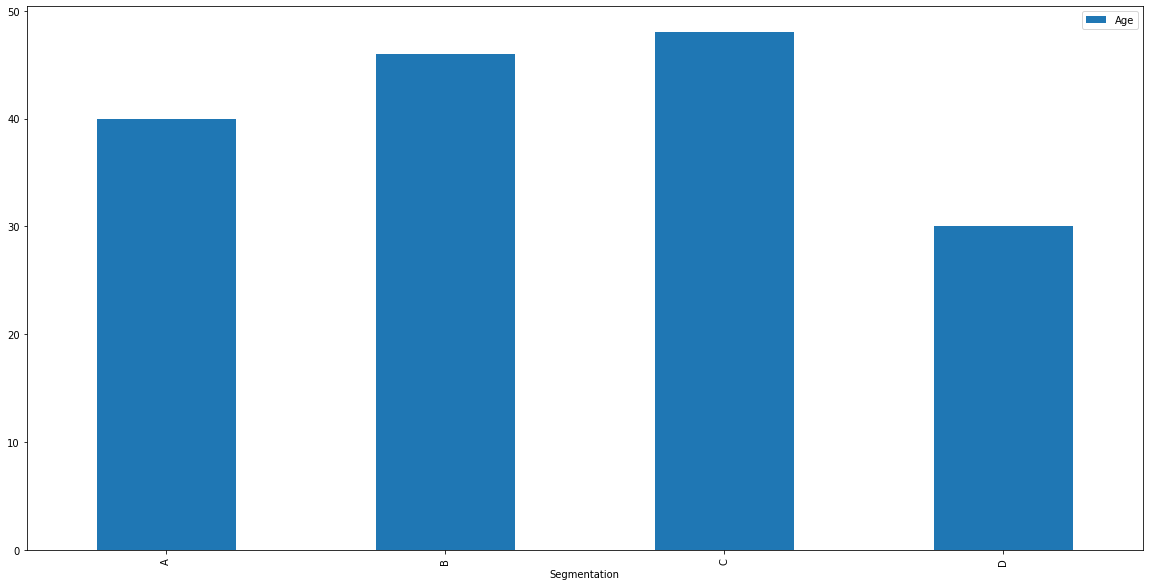

In [11]:
age_pv = pd.pivot_table(customer_data, values = ['Age'], index = ['Segmentation'], aggfunc=np.median)
plt = age_pv.plot(kind='bar', figsize=(20,10))

**Customer Type by Mean Family Size**

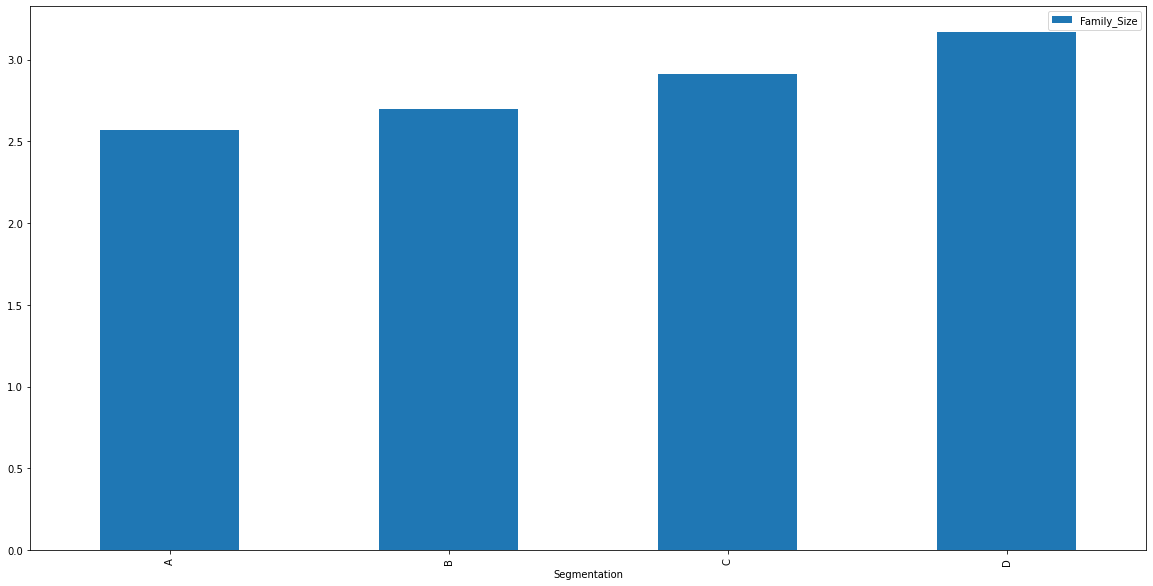

In [12]:
family_pv = pd.pivot_table(customer_data, values = ['Family_Size'], index = ['Segmentation'], aggfunc=np.mean)
plt = family_pv.plot(kind='bar', figsize=(20,10))

**Pipeline for Converting Categorical Data to Ordinal Data and Scaling Floating Point Data**

---

I'm doing preprocessing separately from classification because Pearson correlation doesn't work on categorical data, it needs to be changed to ordinal data first.

In [16]:
# Remove ID column
customer_data = customer_data.drop(columns = 'ID')

# Categorical and Float Attributes
cats = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Var_1', 'Segmentation']
floats = ['Age', 'Work_Experience', 'Family_Size']

# Create pipeline to change categorical data to ordinal data
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])
# Create pipeline to scale continuous data
float_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('float', float_transformer, floats),
        ('cat', cat_transformer, cats)
])

#Scaled and Ordinal Customer Data as a DataFrame
customer_data_proc = pd.DataFrame(preprocessor.fit_transform(customer_data), columns= customer_data.columns)
print(customer_data_proc.head())

     Gender  Ever_Married       Age  ...  Family_Size  Var_1  Segmentation
0 -1.282499     -0.501812  0.760572  ...          2.0    3.0           3.0
1 -0.328606     -0.194765  0.099783  ...          0.0    3.0           0.0
2  1.400325     -0.501812 -1.221797  ...          2.0    5.0           1.0
3  1.400325     -0.808859 -0.561007  ...          1.0    5.0           1.0
4 -0.209369      1.524699  2.082152  ...          1.0    5.0           0.0

[5 rows x 10 columns]


**Pearson Correlation for Customer Segmentation**

In [17]:
customer_data_proc.corr()['Segmentation'].sort_values(ascending=False)

Segmentation       1.000000
Spending_Score     0.169273
Age                0.150409
Family_Size        0.084906
Graduated          0.018805
Ever_Married       0.006918
Var_1             -0.014580
Work_Experience   -0.145316
Profession        -0.176650
Gender            -0.200639
Name: Segmentation, dtype: float64

**Pearson Correlation Heatmap**

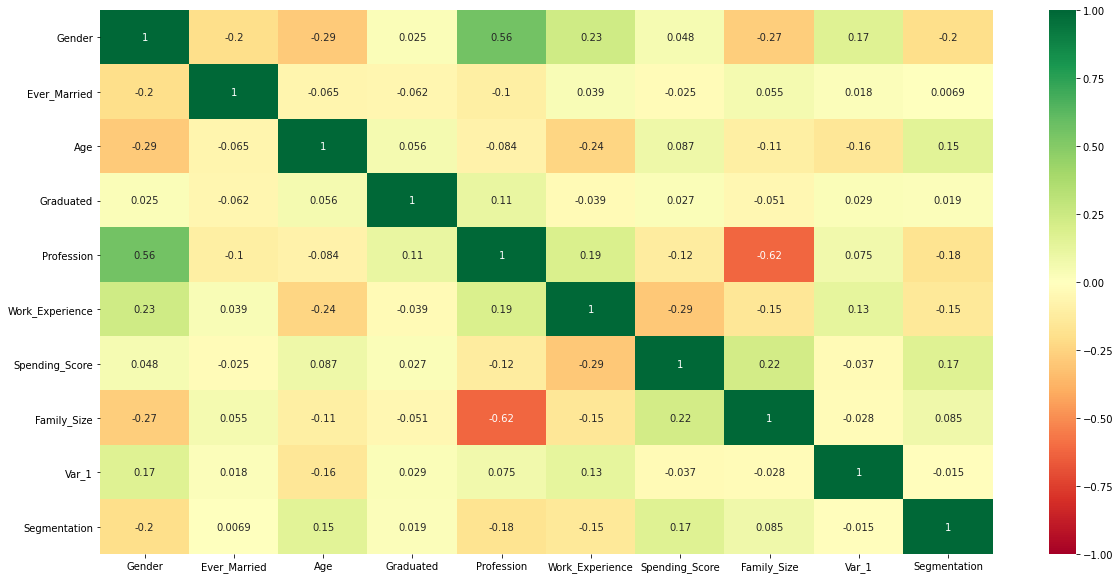

In [20]:
from matplotlib import figure

corr = customer_data_proc.corr(method="pearson")
plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,cmap='RdYlGn', vmin=-1, vmax=+1)

**Split Train and Test Data**

In [21]:
Y = customer_data_proc[['Segmentation']]
X = customer_data_proc.drop(columns=['Segmentation'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)  # Use 80/20 split

print(X_train)
print(X_test)

        Gender  Ever_Married       Age  ...  Spending_Score  Family_Size  Var_1
3083 -0.090133      0.419330 -0.561007  ...             0.0          2.0    1.0
508   0.506050     -0.501812  1.421362  ...             0.0          0.0    3.0
3079 -0.745934     -0.071946 -1.221797  ...             0.0          2.0    5.0
2036 -0.984407     -0.808859 -0.561007  ...             1.0          0.0    4.0
49    0.088722     -0.501812 -1.221797  ...             2.0          2.0    5.0
...        ...           ...       ...  ...             ...          ...    ...
9225 -0.805552      1.647518 -1.221797  ...             5.0          2.0    5.0
4859  2.234981     -0.808859 -0.561007  ...             7.0          0.0    5.0
3264 -0.209369      3.489800 -1.221797  ...             3.0          2.0    5.0
9845  2.592691     -0.501812 -0.561007  ...             7.0          1.0    5.0
2732  0.446432     -0.501812 -0.561007  ...             0.0          2.0    6.0

[8556 rows x 9 columns]
         Gender

**Support Vector Classification - RBF Kernel**

In [22]:
rbf_svc_classifier = SVC(kernel='rbf')

rbf_score = cross_val_score(rbf_svc_classifier, X_train, Y_train, cv=3, scoring="accuracy").mean()

rbf_svc_classifier.fit(X_train, Y_train)

Y_test_pred = rbf_svc_classifier.predict(X_test)

labels = [0, 1, 2, 3]
rbf_cm = confusion_matrix(Y_test, Y_test_pred, labels=labels)

print(rbf_cm)
print(rbf_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[[273  72  75 123]
 [201 112 143  60]
 [131  70 224  71]
 [177  21  23 363]]
0.4694950911640954


**Support Vector Classification - Polynomial Kernel**

In [23]:
poly_svc_classifier = SVC(kernel='poly')

poly_score = cross_val_score(poly_svc_classifier, X_train, Y_train, cv=3, scoring="accuracy").mean()

poly_svc_classifier.fit(X_train, Y_train)
Y_test_pred = poly_svc_classifier.predict(X_test)

labels = [0, 1, 2, 3]
poly_cm = confusion_matrix(Y_test, Y_test_pred, labels=labels)

print(poly_cm)
print(poly_score)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

[[332  40  75  96]
 [247  68 152  49]
 [164  56 211  65]
 [199  16  22 347]]
0.45652173913043476


**Decision Tree Classification - Gini Score**

In [28]:
gini_classifier = DecisionTreeClassifier(criterion='gini')
gini_score = cross_val_score(gini_classifier, X_train, Y_train, cv=3, scoring="accuracy").mean()

gini_classifier.fit(X_train, Y_train)
Y_test_pred = gini_classifier.predict(X_test)

labels = [0, 1, 2, 3]
gini_cm = confusion_matrix(Y_test, Y_test_pred, labels=labels)

print(gini_cm)
print(gini_score)

[[188 147  79 129]
 [142 151 140  83]
 [118 134 172  72]
 [153  73  72 286]]
0.36746143057503505


**Visualization of Gini Score Decision Tree**

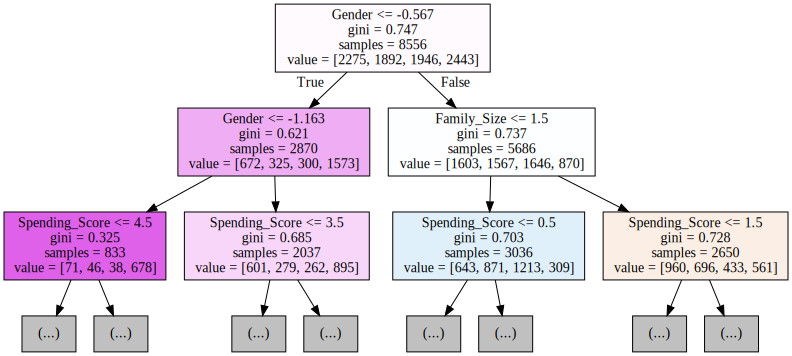

In [29]:
gini_graph_data = export_graphviz(gini_classifier, max_depth=2, feature_names=X_train.columns, filled=True)
gini_graph = graphviz.Source(gini_graph_data, format="png")
gini_graph

**Decision Tree Classification - Entropy Score**

In [30]:
entropy_classifier = DecisionTreeClassifier(criterion='entropy')
entropy_score = cross_val_score(entropy_classifier, X_train, Y_train, cv=3, scoring="accuracy").mean()

entropy_classifier.fit(X_train, Y_train)
Y_test_pred = entropy_classifier.predict(X_test)

labels = [0, 1, 2, 3]
entropy_cm = confusion_matrix(Y_test, Y_test_pred, labels=labels)

print(entropy_cm)
print(entropy_score)

[[195 142  89 117]
 [151 142 143  80]
 [110 133 186  67]
 [149  89  68 278]]
0.36699392239364187


**Visualization of Gini Score Decision Tree**

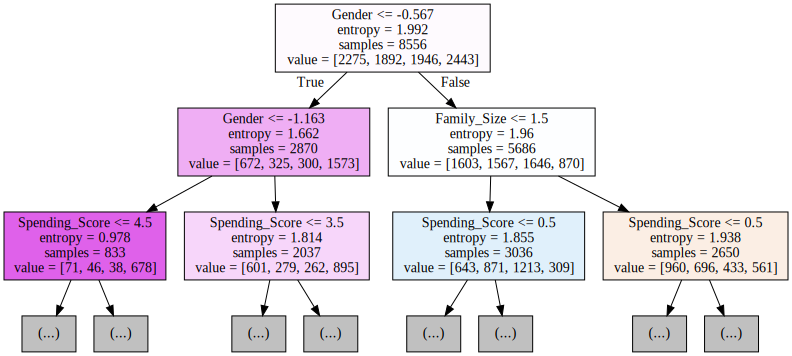

In [31]:
entropy_graph_data = export_graphviz(entropy_classifier, max_depth=2, feature_names=X_train.columns, filled=True)
entropy_graph = graphviz.Source(entropy_graph_data, format="png")
entropy_graph

**Support Vector Classification - RBF Kernel - Grid Search for Hyperparameter Optimization**

In [ ]:
# Drop columns with low correlation scores to improve performance

svc_classifier = SVC()
params = {'kernel':['rbf'], 'gamma':['scale','auto'], 'C': np.arange(650, 750, 10)}  #Note: C range was determined by repeated runs, starting with np.arange(0, 1100, 100), and gradually narrowed down

grid_search = GridSearchCV(svc_classifier, params,  cv=3, n_jobs=6)
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)


In [ ]:
print(grid_search.best_score_)

0.4696119682094437


In [ ]:
#{'C': 700, 'gamma': 'scale', 'kernel': 'rbf'}

Y_test_pred = grid_search.predict(X_test_svc)
labels = [0, 1, 2, 3]
grid_cm = confusion_matrix(Y_test, Y_test_pred, labels=labels)

print(grid_cm)

[[244  76 101 122]
 [177 111 165  63]
 [ 94  68 257  77]
 [143  28  32 381]]


**Decision Tree Classifier - Grid Search for Hyperparameter Optimization**

In [ ]:
tree_classifier = DecisionTreeClassifier()

params = { 'criterion':['gini','entropy'], 'max_depth': np.arange(3, 15), 'min_samples_leaf': np.arange(1, 10), 'min_samples_split': np.arange(2, 10)}
   
grid_search_dt = GridSearchCV(tree_classifier, params, cv=3, n_jobs=6)
grid_search_dt.fit(X_train, Y_train)

print(grid_search_dt.best_score_)
print(grid_search_dt.best_params_)

0.4732351566152408
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [ ]:
print(grid_search_dt.best_score_)
print(grid_search_dt.best_params_)

0.4727676484338476
{'criterion': 'entropy', 'max_depth': 5}
